In [1]:
# imports
import numpy as np
import pandas as pd
import requests
import logging

# finance
from statsmodels.tsa.stattools import grangercausalitytests
import talib as ta

# visualisation
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

# time
import time
from datetime import date, datetime, timedelta 

import warnings

# statistics
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz


In [18]:
# downloading ETH from binance
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # download eth
        coin = ["ETHUSDT"]

        def fetch_crypto_ohlc(coin, interval="1d"):
            url = "https://api.binance.com/api/v1/klines"
        
            # 1y back from today
            start_time = datetime.now() - timedelta(days=1080)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=90)).timestamp() * 1000
                    ),  # fetching 90 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            ohlc_df["ticker"] = coin

            ohlc_df["timestamp"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df.set_index("timestamp", inplace=True)

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100
            
            return ohlc_df[
                [
                    "ticker",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):

            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.dayofweek.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coin:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('eth.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()

if __name__ == "__main__":
        get_coins()

2025-06-28 10:52:07,277 - INFO - Fetching data for ETHUSDT
2025-06-28 10:52:07,612 - INFO - Fetched data for ETHUSDT up to 2024-10-01 00:00:00.001000
2025-06-28 10:52:08,415 - INFO - Fetched data for ETHUSDT up to 2024-12-30 00:00:00.001000
2025-06-28 10:52:09,231 - INFO - Fetched data for ETHUSDT up to 2025-03-30 00:00:00.001000
2025-06-28 10:52:10,028 - INFO - Fetched data for ETHUSDT up to 2025-06-28 00:00:00.001000
2025-06-28 10:52:10,823 - WARNING - No OHLC data found for ETHUSDT.
2025-06-28 10:52:10,847 - INFO - Data fetching and processing complete. Data saved to crypto.csv


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2024-07-04 to 2025-06-28
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          360 non-null    int64   
 1   month         360 non-null    int64   
 2   day           360 non-null    int64   
 3   hour          360 non-null    int64   
 4   ticker        360 non-null    category
 5   open          360 non-null    float64 
 6   high          360 non-null    float64 
 7   low           360 non-null    float64 
 8   close         360 non-null    float64 
 9   price_change  360 non-null    float64 
 10  volume        360 non-null    float64 
dtypes: category(1), float64(6), int64(4)
memory usage: 31.4 KB


In [2]:
# daily returns

# calculate daily returns based on close price
df = pd.read_csv("eth.csv", parse_dates=True, index_col=0)

df["return"] = df["close"].pct_change() * 100

mean_return = df["return"].mean()
median_return = df["return"].median()
volatility = df["return"].std()
skewness = df["return"].skew()
kurtosis = df["return"].kurt()

daily_sharpe = mean_return / volatility
annual_sharpe = daily_sharpe * np.sqrt(365)

print(f"Mean return: {mean_return:.2f}")
print(f"Median return: {median_return:.2f}")
print(f"Volatility: {volatility:.2f}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")
print(f"Daily Sharpe: {daily_sharpe:.2f}")
print(f"Annual Sharpe: {annual_sharpe:.2f}")

Mean return: -0.01
Median return: -0.05
Volatility: 3.90
Skewness: 0.66
Kurtosis: 4.38
Daily Sharpe: -0.00
Annual Sharpe: -0.05


In [3]:
# quantile
q1 = df["return"].quantile(0.25)
q3 = df["return"].quantile(0.75)
print(f"Q1 (25%): {q1:.2f}")
print(f"Q3 (75%): {q3:.2f}")

# value at risk
quantiles = df["return"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
var_95 = df["return"].quantile(0.05)  # value at risk (95%)
var_99 = df["return"].quantile(0.01)  # value at risk (99%)

print(f"VaR 95%: {var_95:.2f}%")
print(f"VaR 99%: {var_99:.2f}%") 

Q1 (25%): -2.12
Q3 (75%): 1.68
VaR 95%: -5.95%
VaR 99%: -9.32%


In [4]:
# key insights:

# near-zero mean return (-0.01%) with negative median (-0.05%) -> slight bearish bias 
# high volatility (3.90% daily) -> approximately 74% annualized volatility
# negative sharpe ratio (-0.05 annualized) 
# positive skewness (0.66) shows asymmetric tail risk -> more frequent large positive moves than negative ones
# high kurtosis (4.38) indicates fat tails -> extreme events occur more frequently
# Wide interquartile range (Q1: -2.12%, Q3: 1.68%) -> significant daily variation
# var 95%: -5.95% -> expect daily losses exceeding 6% roughly once per month (1.52 days a month)
# var 99%: -9.32% -> extreme tail events with losses above 9% occur approximately quarterly


# implications for correlation analysis:
# high volatility regime detection will be critical -> features capturing volatility clustering
# skewed returns show non linear relationships between features 
# fat tails indicate that extreme event indicators (tail risk signals, drawdown metrics) should correlate strongly with volatility

# implications for dag:
# volatility persistence (high daily vol) suggests strong causal chains: volatility_t → volatility_t+1 → return_magnitude
# positive skew with fat tails implies asymmetric causal patterns: upside momentum vs. downside crashes may follow different causal pathways
# var breaches should serve as leading indicators in the causal graph - nodes representing risk regime shifts
# kurtosis signals suggest that extreme event detectors will be important upstream nodes influencing multiple downstream features


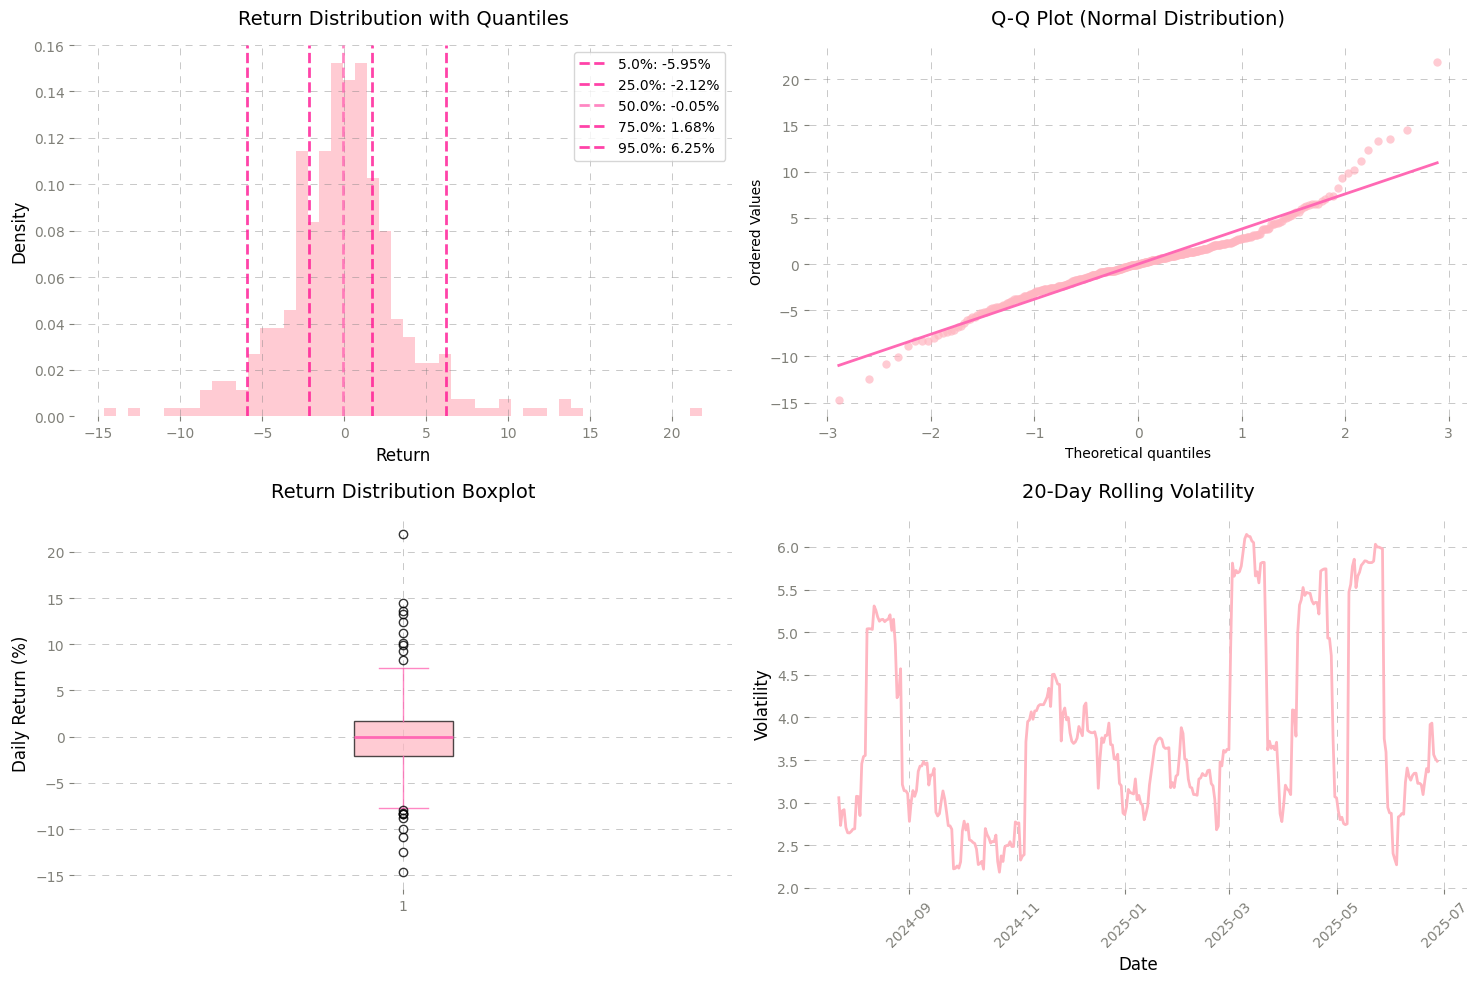

In [5]:
# visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# style
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# histogram return
axes[0,0].hist(df["return"].dropna(), bins=50, alpha=0.7, density=True, 
               color='#FFB6C1', edgecolor='none')
for i, q_val in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
    color = '#FF69B4' if i == 2 else '#FF1493'  # Median hervorheben
    axes[0,0].axvline(df["return"].quantile(q_val), 
                      color=color, linestyle='--', alpha=0.8, linewidth=2,
                      label=f'{q_val*100}%: {df["return"].quantile(q_val):.2f}%')
axes[0,0].set_title("Return Distribution with Quantiles", fontsize=14, pad=15)
axes[0,0].legend(fontsize=10)
axes[0,0].set_xlabel("Return", fontsize=12)
axes[0,0].set_ylabel("Density", fontsize=12)

# q-q plot normal distribution 
stats.probplot(df["return"].dropna(), dist="norm", plot=axes[0,1])
axes[0,1].get_lines()[0].set_markerfacecolor('#FFB6C1')
axes[0,1].get_lines()[0].set_markeredgecolor('none')
axes[0,1].get_lines()[0].set_alpha(0.7)
axes[0,1].get_lines()[1].set_color('#FF69B4')
axes[0,1].get_lines()[1].set_linewidth(2)
axes[0,1].set_title("Q-Q Plot (Normal Distribution)", fontsize=14, pad=15)

# box plot
bp = axes[1,0].boxplot(df["return"].dropna(), patch_artist=True)
bp['boxes'][0].set_facecolor('#FFB6C1')
bp['boxes'][0].set_alpha(0.7)
bp['medians'][0].set_color('#FF69B4')
bp['medians'][0].set_linewidth(2)
for element in ['whiskers', 'fliers', 'caps']:
    for item in bp[element]:
        item.set_color('#FF69B4')
        item.set_alpha(0.8)
axes[1,0].set_ylabel("Daily Return (%)", fontsize=12)
axes[1,0].set_title("Return Distribution Boxplot", fontsize=14, pad=15)

# rolling volatility
df["rolling_vol"] = df["return"].rolling(window=20).std()
axes[1,1].plot(df.index, df["rolling_vol"], color='#FFB6C1', linewidth=2)
axes[1,1].set_title("20-Day Rolling Volatility", fontsize=14, pad=15)
axes[1,1].set_ylabel("Volatility", fontsize=12)
axes[1,1].set_xlabel("Date", fontsize=12)

# remove spines
for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # grid
    ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
    
    # ticks
    [t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
    [t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
    ax.tick_params(axis="x", colors="#808079")
    ax.tick_params(axis="y", colors="#808079")

# special handling for the last subplot (date axis)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("images/return_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# creating new columns, with shift(1) to avoid data leakage and focussed on volatility

# volatility 

df['volatility_7d'] = df['close'].rolling(window=7).std().shift(1)
df['volume_change'] = df['volume'].pct_change().replace([np.inf, -np.inf], np.nan).shift(1)

# volatility regime detection
vol_rolling_quantiles = df['close'].rolling(window=7).std().rolling(30)  # Base volatility for regime
df['vol_regime'] = np.where(df['volatility_7d'] > vol_rolling_quantiles.quantile(0.75).shift(1), 2,  # high vol
                   np.where(df['volatility_7d'] < vol_rolling_quantiles.quantile(0.25).shift(1), 0, 1))  # low/medium voll

# volatility regime transitions
df['vol_regime_change'] = (df['vol_regime'] != df['vol_regime'].shift(1)).astype(int)

# volatility momentum 
df['vol_momentum'] = df['volatility_7d'] / df['volatility_7d'].shift(1).rolling(14).mean() - 1

# extreme move detection 
df['extreme_down'] = (df['return'] < df['return'].rolling(90).quantile(0.05).shift(1)).astype(int)
df['extreme_up'] = (df['return'] > df['return'].rolling(90).quantile(0.95).shift(1)).astype(int)


# mean reversion after extremes
df['extreme_reversal_setup'] = ((df['extreme_down'].shift(1) == 1) & 
                                (df['return'] > 0)).astype(int)

# volatility expansion 
df['vol_expansion'] = (df['volatility_7d'] > df['volatility_7d'].shift(1) * 1.5).astype(int)

# volatility persistence
df['vol_persistence'] = (df['volatility_7d'] > df['volatility_7d'].shift(1)).astype(int)

# draw-down indikator
df['running_max'] = df['close'].rolling(30).max().shift(1)
df['drawdown'] = (df['close'] - df['running_max']) / df['running_max']
df['deep_drawdown'] = (df['drawdown'] < -0.15).astype(int)


# volume anomalies
df['volume_roc'] = (df['volume'] / df['volume'].shift(5) - 1).shift(1)
    
df['volume_zscore'] = ((df['volume'] - df['volume'].rolling(30).mean()) / 
                       df['volume'].rolling(30).std()).shift(1)
df['volume_spike'] = (df['volume_zscore'] > 2).astype(int)

df['vwap'] = (df['volume'] * df['close']).rolling(20).sum() / df['volume'].rolling(20).sum()
df['vwap_distance'] = ((df['close'] - df['vwap'].shift(1)) / df['vwap'].shift(1)).shift(1)
    

# fat tails
# extreme days
extreme_events = (df['extreme_down'] | df['extreme_up']).astype(int)
df['extreme_streak'] = extreme_events.groupby((extreme_events != extreme_events.shift()).cumsum()).cumsum()

df['tail_risk_signal'] = ((df['volatility_7d'] > df['volatility_7d'].rolling(60).quantile(0.9)) & 
                          (df['volume_zscore'] > 1.5)).astype(int)

# var indicators
df['var_breach_95'] = (df['return'].shift(1) < -0.0595).astype(int)  # -5.95%
df['var_breach_99'] = (df['return'].shift(1) < -0.0932).astype(int)  # -9.32%

# var position sizing
df['position_size_factor'] = 1 / (df['volatility_7d'] / df['volatility_7d'].rolling(60).mean())

# skew indicator
df['upside_momentum'] = (df['return'].shift(1) > df['return'].rolling(21).quantile(0.75).shift(1)).astype(int)



# talib
def add_ta_indicators(df):
    # ensure correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # create shifted versions as new columns
    df["open_lag1"] = df["open"].shift(1)
    df["high_lag1"] = df["high"].shift(1)
    df["low_lag1"] = df["low"].shift(1)
    df["close_lag1"] = df["close"].shift(1)
    df["volume_lag1"] = df["volume"].shift(1)

    # ta indicators based on shifted inputs
    df['atr_14'] = ta.ATR(df['high_lag1'], df['low_lag1'], df['close_lag1'], timeperiod=14)
    df['rsi'] = ta.RSI(df['close_lag1'], timeperiod=14)

    upper, middle, lower = ta.BBANDS(df['close_lag1'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['bb_upper'] = upper
    df['bb_middle'] = middle
    df['bb_lower'] = lower
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['close_lag1'] 
    df['bb_position'] = (df['close_lag1'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    # handle edge cases
    df['bb_position'] = df['bb_position'].clip(0, 1)  # Keep within [0,1]
    df['bb_width'] = df['bb_width'].fillna(0)
    
    return df


df = add_ta_indicators(df)

# vol adjusted atr
df['atr_normalized'] = df['atr_14'] / df['close'].shift(1)

# rsi divergence 
df['rsi_oversold_extreme'] = (df['rsi'] < 25).astype(int)  
df['rsi_overbought_extreme'] = (df['rsi'] > 85).astype(int) 

# market stress
df['market_stress_vol'] = (df['vol_regime'] == 2).astype(int)
df['market_stress_volume'] = (df['volume_zscore'] > 2).astype(int) 
df['market_stress_streak'] = (df['extreme_streak'] > 2).astype(int)  # Changed from 1 to 2

# composite market stress (weighted to avoid over-emphasis)
df['market_stress'] = (df['market_stress_vol'] * 0.4 + 
                       df['market_stress_volume'] * 0.3 + 
                       df['market_stress_streak'] * 0.3)


# delete now unnecessary column
df.drop(columns=['atr_14', 'running_max', 'market_stress_vol', 
                 'market_stress_volume', 'market_stress_streak'], 
        inplace=True, errors='ignore')


In [7]:
# checking if there are infinity data and replace with nan
infinity_check = df.replace([np.inf, -np.inf], np.nan).isnull().sum()

# print columns that have infinity
print("Columns with infinity:")
print(infinity_check[infinity_check > 0])


# using forwardfill
df = df.ffill()
df = df.bfill()

#checking if it worked
print(df.isnull().sum().sum())


Columns with infinity:
return                    1
rolling_vol              20
volatility_7d             7
volume_change             2
vol_momentum             21
drawdown                 30
volume_roc                6
volume_zscore            30
vwap                     19
vwap_distance            21
position_size_factor    258
open_lag1                 1
high_lag1                 1
low_lag1                  1
close_lag1                1
volume_lag1               1
rsi                      15
bb_upper                 20
bb_middle                20
bb_lower                 20
bb_position              20
atr_normalized           15
dtype: int64
0


In [8]:
df.head(3)

,year,month,day,hour,ticker,open,high,low,close,price_change,...,rsi,bb_upper,bb_middle,bb_lower,bb_width,bb_position,atr_normalized,rsi_oversold_extreme,rsi_overbought_extreme,market_stress
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-07-03,2024,7,2,0,ETHUSDT,3421.35,3432.10,3251.00,3295.48,-3.678957,...,53.859577,3643.566183,3245.679,2847.791817,0.0,0.743688,0.050093,0,0,0.0
2024-07-04,2024,7,3,0,ETHUSDT,3295.49,3313.45,3050.34,3059.70,-7.154930,...,53.859577,3643.566183,3245.679,2847.791817,0.0,0.743688,0.050093,0,0,0.0
2024-07-05,2024,7,4,0,ETHUSDT,3059.70,3110.00,2810.00,2981.78,-2.546655,...,53.859577,3643.566183,3245.679,2847.791817,0.0,0.743688,0.050093,0,0,0.0


In [9]:
df.columns

Index(['year', 'month', 'day', 'hour', 'ticker', 'open', 'high', 'low',
       'close', 'price_change', 'volume', 'return', 'rolling_vol',
       'volatility_7d', 'volume_change', 'vol_regime', 'vol_regime_change',
       'vol_momentum', 'extreme_down', 'extreme_up', 'extreme_reversal_setup',
       'vol_expansion', 'vol_persistence', 'drawdown', 'deep_drawdown',
       'volume_roc', 'volume_zscore', 'volume_spike', 'vwap', 'vwap_distance',
       'extreme_streak', 'tail_risk_signal', 'var_breach_95', 'var_breach_99',
       'position_size_factor', 'upside_momentum', 'open_lag1', 'high_lag1',
       'low_lag1', 'close_lag1', 'volume_lag1', 'rsi', 'bb_upper', 'bb_middle',
       'bb_lower', 'bb_width', 'bb_position', 'atr_normalized',
       'rsi_oversold_extreme', 'rsi_overbought_extreme', 'market_stress'],
      dtype='object')

In [10]:
# reasons to check for correlation:

# checking feature correlation to identify redundancy, multicollinearity, (statistical relationships), mistakes in feature engineering
# highly correlated features often carry duplicate information -> can confuse some models and lead to overfitting

# correlation alone is not enough to decide feature removal 
# -> some features weakly correlated with the target (return) but still valuable in combination with others!

# The goal here is to flag strongly correlated feature pairs |corr| > 0.8
# and flag less relevant one on return correlation


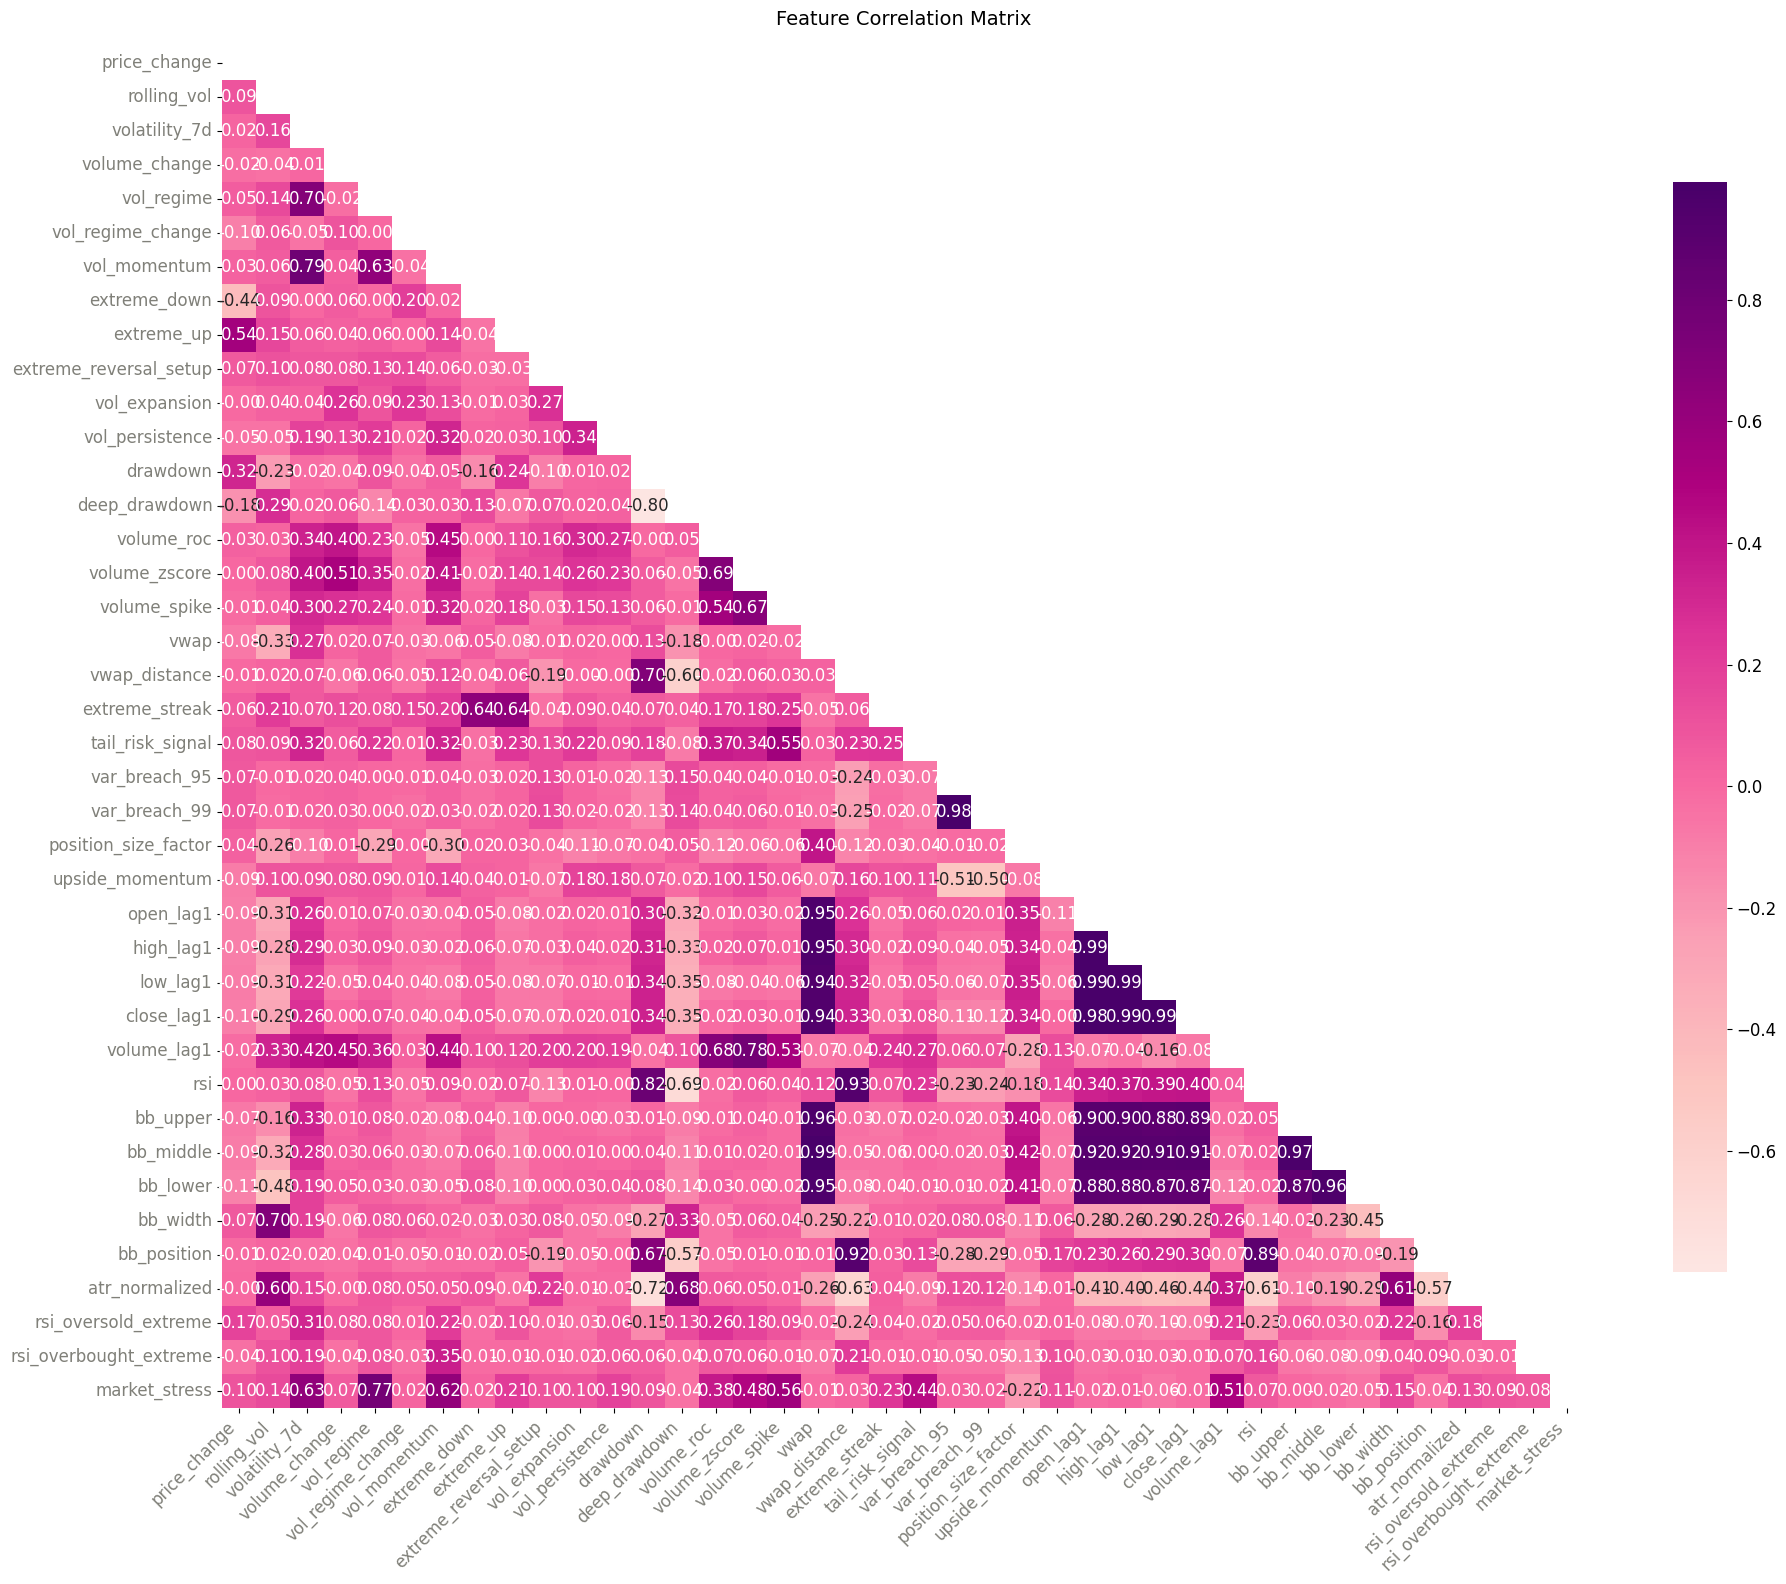

Highly Correlating Features (|corr| > 0.8):
        Feature_1      Feature_2  Correlation
18      high_lag1     close_lag1     0.993881
11      open_lag1      high_lag1     0.993459
6            vwap      bb_middle     0.991698
22       low_lag1     close_lag1     0.991241
12      open_lag1       low_lag1     0.988494
17      high_lag1       low_lag1     0.988161
13      open_lag1     close_lag1     0.984663
10  var_breach_95  var_breach_99     0.983465
30       bb_upper      bb_middle     0.971246
5            vwap       bb_upper     0.963621
32      bb_middle       bb_lower     0.961555
1            vwap      open_lag1     0.953356
7            vwap       bb_lower     0.953066
2            vwap      high_lag1     0.952429
4            vwap     close_lag1     0.944517
3            vwap       low_lag1     0.940449
8   vwap_distance            rsi     0.928686
15      open_lag1      bb_middle     0.923121
20      high_lag1      bb_middle     0.920896
9   vwap_distance    bb_position    

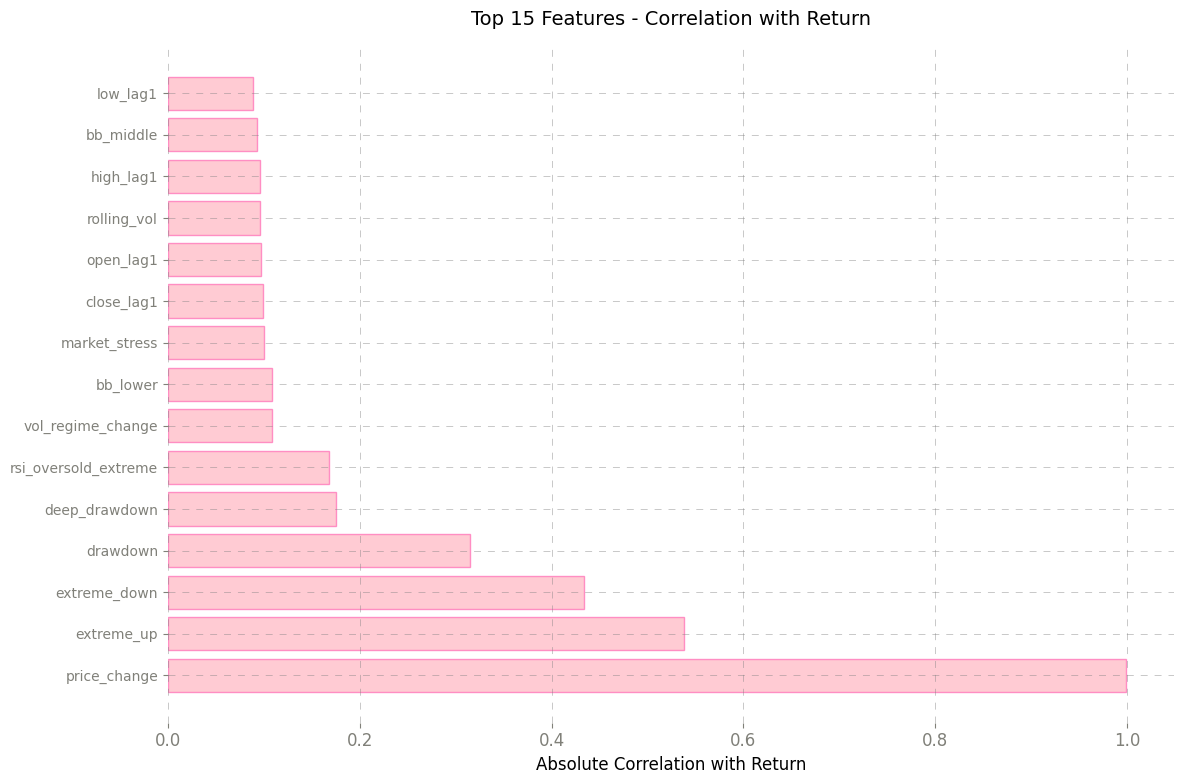

In [ ]:
# checking for correlation

# defining features
feature_cols = [col for col in df.columns if col not in ['date', 'year', 'month', 'day', 'hour', 'ticker', 'open', 'high', 'low', 'close', 'return']]

# calc corr matrix 
correlation_matrix = df[feature_cols].corr()

# heatmap
plt.figure(figsize=(20, 16))

# style settings
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) 
ax = sns.heatmap(correlation_matrix, mask=mask, annot=True, 
                 cmap='RdPu', center=0, square=True, fmt='.2f', 
                 cbar_kws={"shrink": .8})

ax.set_title('Feature Correlation Matrix', fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right', color='#808079')
plt.yticks(rotation=0, color='#808079')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("images/correlation.png", dpi=300, bbox_inches='tight')
plt.show()

# highly corr features (|corr| > 0.8)
def find_high_correlations(corr_matrix, threshold=0.8):
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append({
                    'Feature_1': corr_matrix.columns[i],
                    'Feature_2': corr_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)

high_corr_df = find_high_correlations(correlation_matrix, threshold=0.8)
print("Highly Correlating Features (|corr| > 0.8):")
print(high_corr_df)

# groups based on high corr
def group_correlated_features(corr_matrix, threshold=0.7):
    processed = set()
    groups = []
    
    for i, feature1 in enumerate(corr_matrix.columns):
        if feature1 in processed:
            continue
            
        # Finde alle Features, die stark mit feature1 korrelieren
        group = [feature1]
        for j, feature2 in enumerate(corr_matrix.columns):
            if i != j and feature2 not in processed:
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    group.append(feature2)
                    processed.add(feature2)
        
        if len(group) > 1:
            groups.append(group)
            processed.update(group)
    
    return groups

feature_groups = group_correlated_features(correlation_matrix, threshold=0.7)
print(f"\nCorrelating Feature-Group (|corr| > 0.7):")
for i, group in enumerate(feature_groups):
    print(f"Group {i+1}: {group}")

# feature cor return
return_corr = df[feature_cols + ['return']].corr()['return'].drop('return').abs().sort_values(ascending=False)
print(f"\nTop 15 Features Return Correlation:")
print(return_corr.head(15))

# feature reduction
def recommend_feature_reduction(high_corr_df, return_corr, threshold=0.8):
    """find features to delete"""
    to_remove = set()
    recommendations = []
    
    for _, row in high_corr_df.iterrows():
        if abs(row['Correlation']) > threshold:
            feat1, feat2 = row['Feature_1'], row['Feature_2']
            
            # keeping the one with higher return
            if return_corr[feat1] > return_corr[feat2]:
                to_remove.add(feat2)
                recommendations.append(f"Remove '{feat2}' (corr={row['Correlation']:.3f} mit '{feat1}', low Return Corr: {return_corr[feat2]:.3f})")
            else:
                to_remove.add(feat1)
                recommendations.append(f"Remove '{feat1}' (corr={row['Correlation']:.3f} mit '{feat2}', low Return Corr: {return_corr[feat1]:.3f})")
    
    return list(to_remove), recommendations

features_to_remove, recommendations = recommend_feature_reduction(high_corr_df, return_corr)
print(f"\n Consider removing:")
for rec in recommendations:
    print(f"- {rec}")

# top correlations with return
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# style settings
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# plot top 15 correlations with return
top_15_corr = return_corr.head(15)
bars = ax.barh(range(len(top_15_corr)), top_15_corr.values, 
               color='#FFB6C1', alpha=0.7, edgecolor='#FF69B4', linewidth=1)

# styling
ax.set_yticks(range(len(top_15_corr)))
ax.set_yticklabels(top_15_corr.index, fontsize=10)
ax.set_xlabel('Absolute Correlation with Return', fontsize=12)
ax.set_title('Top 15 Features - Correlation with Return', fontsize=14, pad=15)

# remove spines and add grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# tick colors
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
ax.tick_params(axis="x", colors="#808079")
ax.tick_params(axis="y", colors="#808079")

plt.tight_layout()
plt.savefig("images/top_correlations_return.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# key findings:

# high corr:
# bb_upper, bb_middle, bb_lower show expected mathematical interdependence (0.87-0.97 correlation)
# rsi and drawdown are highly correlated (0.82), both capturing oversold conditions from different perspectives
# volatility measures cluster together, indicating redundancy in volatility feature engineering

# predictive value insights:
# extreme movement indicators (extreme_up: 0.54, extreme_down: 0.43) show strongest return correlation
# traditional technical indicators (rsi, bb) have surprisingly low return correlation
# drawdown measures provide moderate predictive signal (0.31 correlation)

# candidates for removal: 
# bb_upper, bb_middle 
# too many volume based features -> clustering but individually weak return correlation

# critical limitations:
# analysis only captures linear relationships -> non-linear patterns missed
# static correlation may not reflect dynamic market regime changes
# individual feature correlation doesn't account for ensemble effects in ML models


In [13]:
# coding causal graph (DAG)	for assumptions about cause → effect
# for structuring the model, avoiding data leakage, guiding feature engineering
# it is manually made, declarative (what do i believe?)
# structure	based on my assumptions and domain knowledge	

# goal: clarity about my own assumptions


In [14]:
# manual directed scyclic graph


causal_features = [
    # core price/volume
    'volume', 'return', 'volatility_7d', 'close',
    
    # volume dynamics
    'volume_change', 'volume_zscore', 'volume_spike',
    
    # volatility regime structure
    'vol_regime', 'vol_regime_change', 'vol_momentum', 'vol_expansion', 'vol_persistence',
    
    # extreme events (critical for fat tails)
    'extreme_down', 'extreme_up', 'extreme_reversal_setup', 'extreme_streak',
    
    # risk metrics (var insights)
    'drawdown', 'deep_drawdown', 'tail_risk_signal', 'var_breach_95', 'var_breach_99',
    
    # technical indicators
    'rsi', 'bb_width', 'bb_position', 'atr_normalized', 
    'rsi_oversold_extreme', 'rsi_overbought_extreme',
    
    # momentum (positive skew)
    'upside_momentum', 'position_size_factor',
    
    # composite stress
    'market_stress'
]


edges = [
    
    # volatility persistence chain (high daily vol → clustering)
    ('close', 'volatility_7d'),
    ('volatility_7d', 'vol_regime'),
    ('vol_regime', 'vol_regime_change'),
    ('volatility_7d', 'vol_momentum'),
    ('vol_momentum', 'vol_expansion'),
    ('vol_expansion', 'vol_persistence'),
    
    # var breach → regime shift chain (monthly/quarterly patterns)
    ('return', 'var_breach_95'),
    ('return', 'var_breach_99'),
    ('var_breach_95', 'vol_regime_change'),  # var breach triggers regime shift
    ('var_breach_99', 'vol_regime_change'),  # extreme var breach
    ('var_breach_95', 'market_stress'),      # var breach increases stress
    ('var_breach_99', 'market_stress'),      # extreme breach → high stress
    
    # extreme event propagation (fat tails → clustering)
    ('return', 'extreme_down'),
    ('return', 'extreme_up'),
    ('extreme_down', 'extreme_streak'),
    ('extreme_up', 'extreme_streak'),
    ('extreme_streak', 'tail_risk_signal'),  # streaks indicate tail risk
    ('tail_risk_signal', 'vol_expansion'),   # tail risk → volatility expansion
    
    # asymetric momentum chains (positive skew patterns)
    ('return', 'upside_momentum'),
    ('upside_momentum', 'volume_spike'),     # positive skew → volume surges
    ('volume_spike', 'vol_expansion'),       # volume surge → volatility
    
    # volume dynamics chain
    ('volume', 'volume_change'),
    ('volume_change', 'volume_zscore'),
    ('volume_zscore', 'volume_spike'),
    ('volume_spike', 'market_stress'),       # volume anomalies → stress
    
    # drawdown cascade (risk propagation)
    ('return', 'drawdown'),
    ('drawdown', 'deep_drawdown'),
    ('deep_drawdown', 'tail_risk_signal'),   # deep drawdowns signal tail risk
    ('deep_drawdown', 'position_size_factor'), # risk management response
    
    # technical indicator chain
    ('close', 'rsi'),
    ('rsi', 'rsi_oversold_extreme'),
    ('rsi', 'rsi_overbought_extreme'),
    ('rsi_oversold_extreme', 'extreme_reversal_setup'),
    ('rsi_overbought_extreme', 'extreme_reversal_setup'),
    
    # bollinger bands chain
    ('close', 'bb_width'),
    ('close', 'bb_position'),
    ('bb_width', 'vol_expansion'),           # bb width indicates volatility
    ('bb_position', 'extreme_reversal_setup'), # bb extremes → reversals
    
    # atr normalization
    ('close', 'atr_normalized'),
    ('volatility_7d', 'atr_normalized'),     # atr adjusted by regime
    ('atr_normalized', 'position_size_factor'), # atr → risk management
    
    # market stress aggregation
    ('vol_regime_change', 'market_stress'),
    ('extreme_streak', 'market_stress'),
    ('tail_risk_signal', 'market_stress'),
    ('deep_drawdown', 'market_stress'),
    
    # feedback loops
    ('market_stress', 'vol_persistence'),
    ('market_stress', 'position_size_factor'),
]



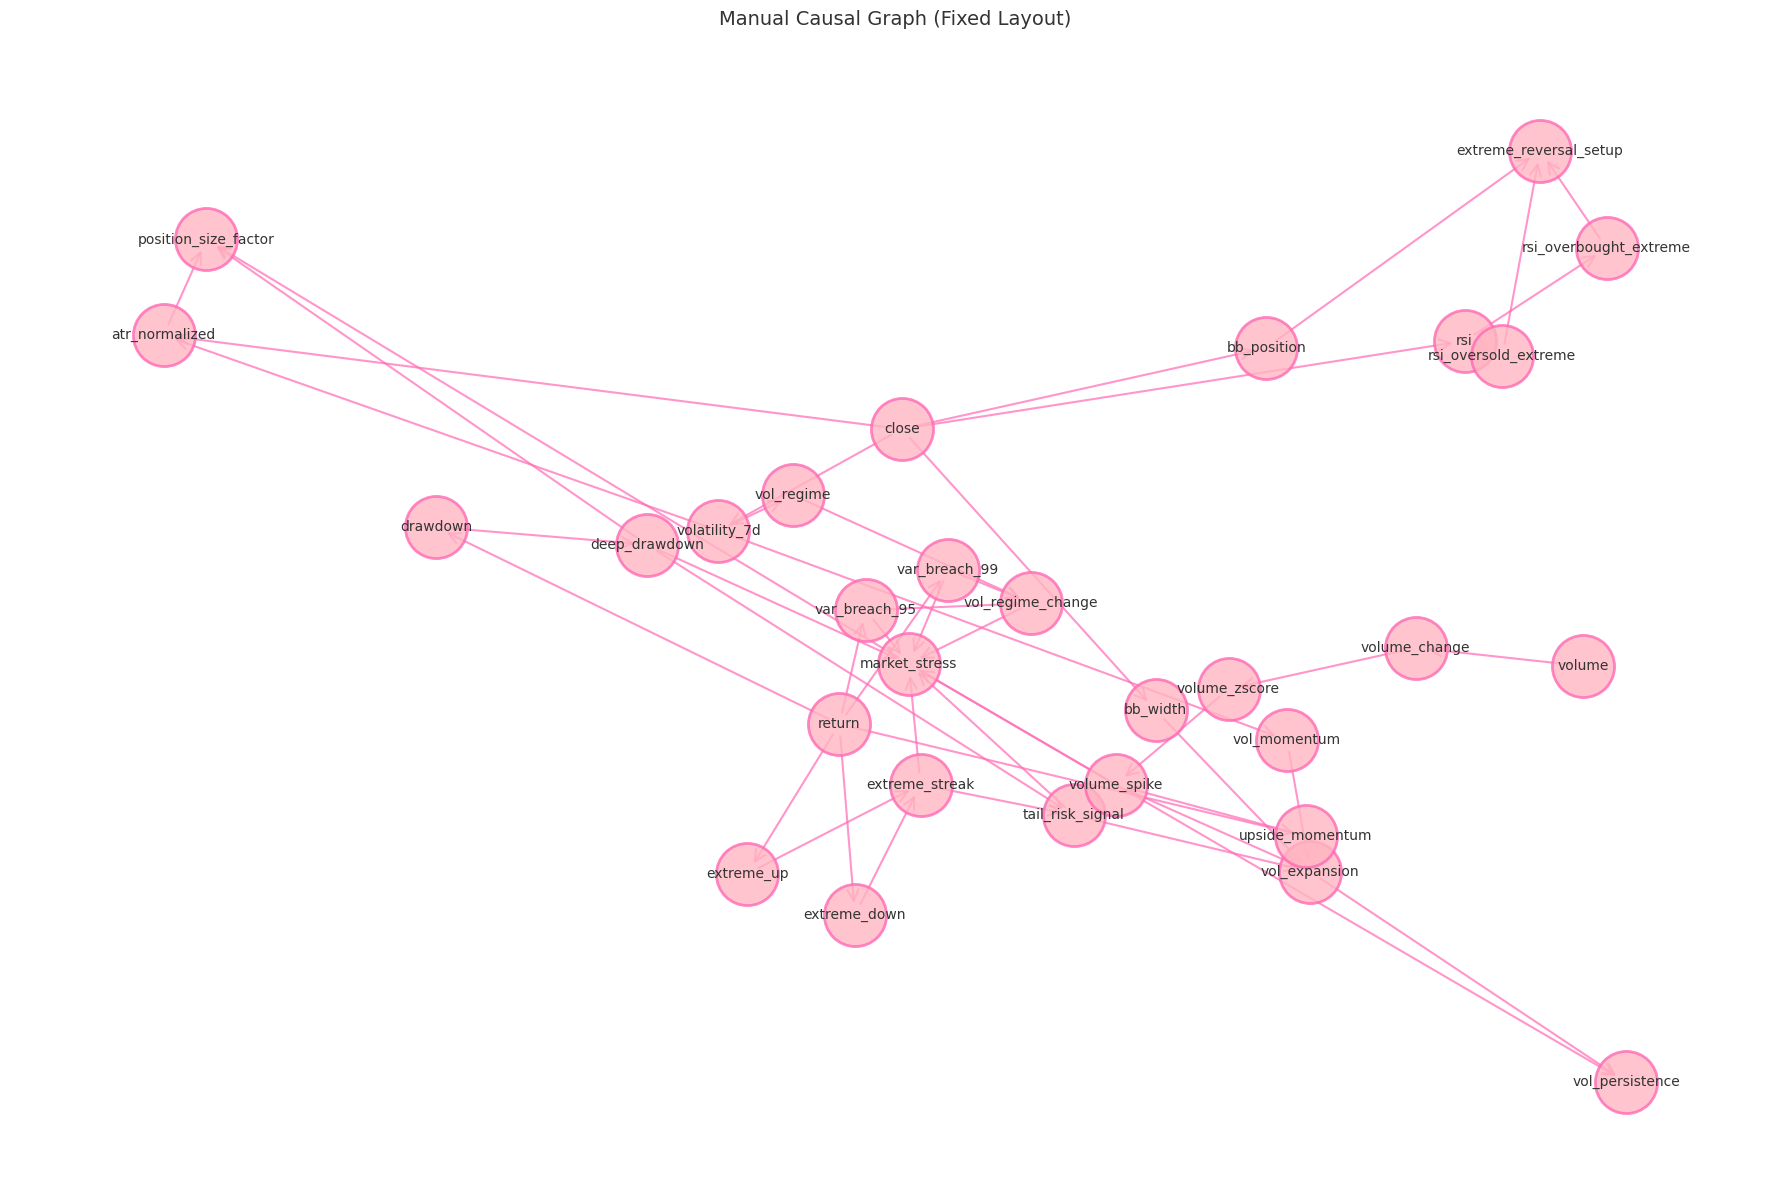

In [15]:
# dag visualization
G = nx.DiGraph()
G.add_edges_from(edges)

fig, ax = plt.subplots(figsize=(18, 12))

# font styling
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 10

# fixed seed layout
pos = nx.spring_layout(G, k=0.3, seed=42) 

nx.draw_networkx_nodes(G, pos, 
                       node_size=2000, 
                       node_color='#FFB6C1', 
                       alpha=0.8,
                       edgecolors='#FF69B4', 
                       linewidths=2)

nx.draw_networkx_labels(G, pos, 
                        font_size=10, 
                        font_color='#333333', 
                        font_weight='normal')

nx.draw_networkx_edges(G, pos, 
                       edge_color='#FF69B4',  
                       arrowsize=20,
                       arrowstyle='->', 
                       width=1.5,
                       alpha=0.7)

# style plot area
ax.set_title("Manual Causal Graph (Fixed Layout)", 
             fontsize=14, pad=20, color='#333333')

# remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("images/dag_manual.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [ ]:
# now we apply pc algorithm to test the assumptions
# is a constraint based causal structure learning method
# analyzes data and tests statistical independence between variables to reconstruct the suspected causal relationships
# fisherz tests: are two variables conditionally independent?
# empirical causal discovery, signal hierarchy
# alpha=0.05: significance level, the threshold at which dependency "real"
# result: causal model with directed edges, a dag
# convert to networkx for visualization & analysis (out-degree, in-degree, etc.)


  0%|          | 0/37 [00:00<?, ?it/s]

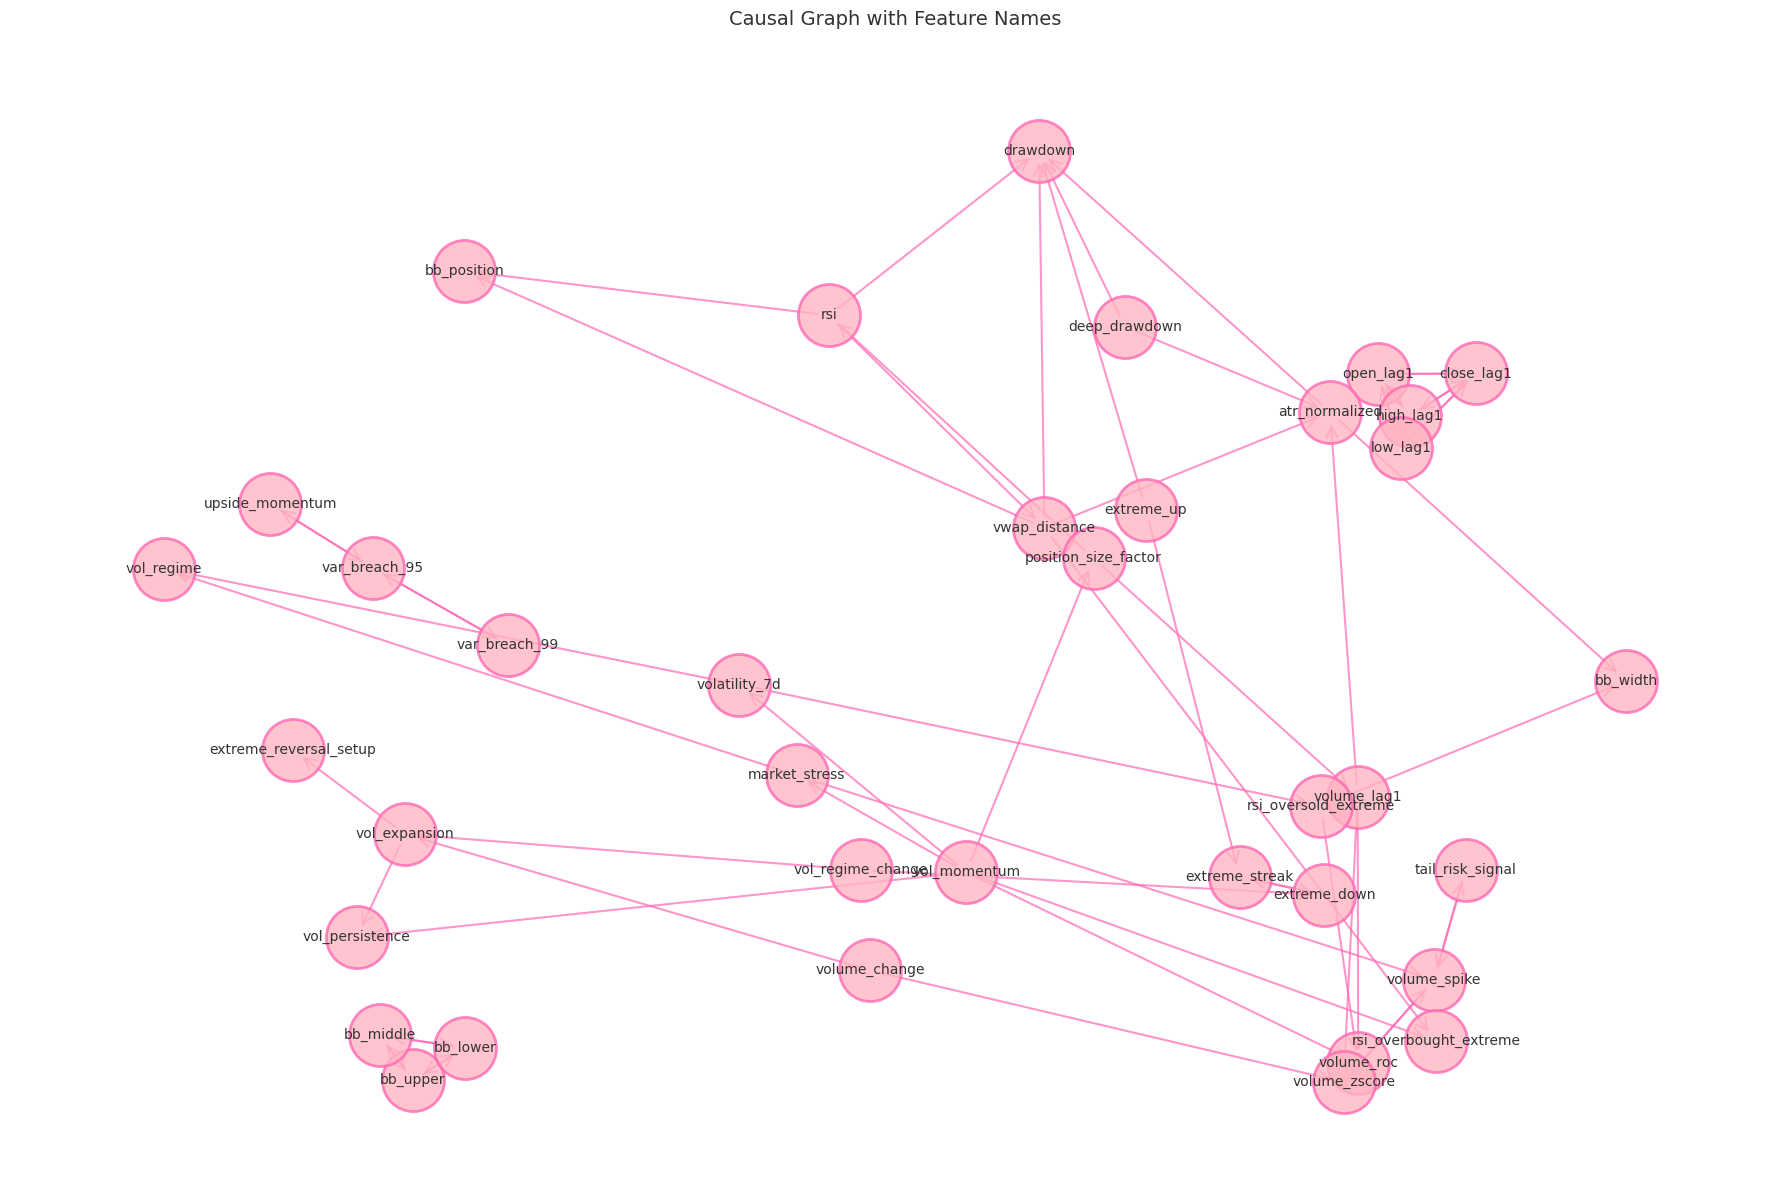

=== ENHANCED CAUSAL ANALYSIS FOR TRADING ===
Number of Indicators: 37
Number of Causal Relationships: 66

LAG FEATURES: 5
TECHNICAL INDICATORS: 32

 TOP CAUSAL DRIVERS (influence others):
  vol_momentum [TECH]: 6 → (influences 6 others)
  vwap_distance [TECH]: 4 → (influences 4 others)
  open_lag1 [LAG]: 3 → (influences 3 others)
  high_lag1 [LAG]: 3 → (influences 3 others)
  low_lag1 [LAG]: 3 → (influences 3 others)
  close_lag1 [LAG]: 3 → (influences 3 others)
  volume_lag1 [LAG]: 3 → (influences 3 others)

 TOP CAUSAL TARGETS (are influenced):
  drawdown [TECH]: ← 5 (influenced by 5 others)
  volume_roc [TECH]: ← 4 (influenced by 4 others)
  volume_zscore [TECH]: ← 4 (influenced by 4 others)
  volume_spike [TECH]: ← 3 (influenced by 3 others)
  open_lag1 [LAG]: ← 3 (influenced by 3 others)
  high_lag1 [LAG]: ← 3 (influenced by 3 others)
  low_lag1 [LAG]: ← 3 (influenced by 3 others)

 CENTRAL HUB INDICATORS (excluding lag features):
  vol_momentum: 6 Total Connections
  volume_zscor

In [18]:
# pc-algorithm dag

causal_features = ['volatility_7d', 'volume_change', 'vwap_distance',
       'vol_regime', 'vol_regime_change', 'vol_momentum', 'extreme_down',
       'extreme_up', 'extreme_reversal_setup', 'vol_expansion', 'volume_roc',
       'vol_persistence', 'drawdown', 'deep_drawdown', 'volume_zscore',
       'volume_spike', 'extreme_streak', 'tail_risk_signal', 'var_breach_95',
       'var_breach_99', 'position_size_factor', 'upside_momentum', 'open_lag1',
       'high_lag1', 'low_lag1', 'close_lag1', 'volume_lag1', 'rsi', 'bb_upper',
       'bb_middle', 'bb_lower', 'bb_width', 'bb_position', 'atr_normalized',
       'rsi_oversold_extreme', 'rsi_overbought_extreme', 'market_stress']

# prepare data
data = df[causal_features].dropna().values  

# run pc algorithm
cg = pc(data=data, indep_test_func=fisherz, alpha=0.05)

# create networkx graph 
def create_nx_graph_from_causal_graph(causal_graph, node_names):
    
    G = nx.DiGraph()
    G.add_nodes_from(node_names)
    
    # extract adjacency matrix
    adj_matrix = causal_graph.graph
    
    # edges based on adjacency matrix
    for i in range(len(node_names)):
        for j in range(len(node_names)):
            if adj_matrix[i, j] == 1:  # directed edge from i to j
                G.add_edge(node_names[i], node_names[j])
            elif adj_matrix[i, j] == -1:  # directed edge from j to i
                G.add_edge(node_names[j], node_names[i])
    
    return G

# create networkx graph
g = create_nx_graph_from_causal_graph(cg.G, causal_features)

# plot
fig, ax = plt.subplots(figsize=(18, 12))

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 10

# fixed seed layout
pos = nx.spring_layout(g, k=0.3, seed=42)

# color scheme
nx.draw_networkx_nodes(g, pos, 
                       node_size=2000, 
                       node_color='#FFB6C1', 
                       alpha=0.8,
                       edgecolors='#FF69B4', 
                       linewidths=2)

nx.draw_networkx_labels(g, pos, 
                        font_size=10, 
                        font_color='#333333',  
                        font_weight='normal')

nx.draw_networkx_edges(g, pos, 
                       edge_color='#FF69B4', 
                       arrowsize=20,
                       arrowstyle='->', 
                       width=1.5,
                       alpha=0.7)

# style
ax.set_title("Causal Graph with ETH Feature Names, 1y Data", 
             fontsize=14, pad=20, color='#333333')

# remove spines
for spine in ax.spines.values():
    spine.set_visible(False)


plt.tight_layout()
plt.savefig("images/algo_dag.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()


# causal relationship analysis for trading
def analyze_causal_relationships_improved(graph, features):
    
    out_degrees = dict(graph.out_degree())
    in_degrees = dict(graph.in_degree())
    
    print("=== ENHANCED CAUSAL ANALYSIS FOR TRADING ===")
    print(f"Number of Indicators: {graph.number_of_nodes()}")
    print(f"Number of Causal Relationships: {graph.number_of_edges()}")
    
    # separate lag features from indicators
    lag_features = [f for f in features if '_lag' in f]
    technical_features = [f for f in features if '_lag' not in f]
    
    print(f"\nLAG FEATURES: {len(lag_features)}")
    print(f"TECHNICAL INDICATORS: {len(technical_features)}")
    
    print("\n TOP CAUSAL DRIVERS (influence others):")
    for var, degree in sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:7]:
        indicator_type = "LAG" if "_lag" in var else "TECH"
        print(f"  {var} [{indicator_type}]: {degree} → (influences {degree} others)")
    
    print("\n TOP CAUSAL TARGETS (are influenced):")  
    for var, degree in sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:7]:
        indicator_type = "LAG" if "_lag" in var else "TECH"
        print(f"  {var} [{indicator_type}]: ← {degree} (influenced by {degree} others)")
    
    # identify isolated nodes
    isolated = [node for node in graph.nodes() if graph.degree(node) == 0]
    if isolated:
        print(f"\nISOLATED INDICATORS: {isolated}")
    
    # central nodes (excluding lag features for better insight)
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in graph.nodes()}
    technical_hubs = {k: v for k, v in total_degrees.items() if '_lag' not in k}
    
    print("\n CENTRAL HUB INDICATORS (excluding lag features):")
    for var, degree in sorted(technical_hubs.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {var}: {degree} Total Connections")
    
    return out_degrees, in_degrees, total_degrees, lag_features, technical_features

# perform analysis
out_deg, in_deg, total_deg, lag_feats, tech_feats = analyze_causal_relationships_improved(g, causal_features)

# trading signal hierarchy
print("\n" + "="*60)
print("IMPROVED TRADING SIGNAL HIERARCHY")
print("="*60)

# feature categorization for trading
def categorize_trading_features(features):
    
    lag_features = [f for f in features if '_lag' in f]
    
    # price action indicators
    price_indicators = [f for f in features if any(x in f.lower() for x in 
                       ['extreme_down', 'extreme_up', 'extreme_reversal', 'drawdown', 'deep_drawdown'])]
    
    # volume indicators
    volume_indicators = [f for f in features if any(x in f.lower() for x in 
                        ['volume_change', 'volume_zscore', 'volume_spike']) and 'momentum' not in f.lower()]
    
    # volatility indicators
    volatility_indicators = [f for f in features if any(x in f.lower() for x in 
                           ['volatility', 'vol_regime', 'vol_expansion', 'vol_persistence', 'var_breach', 'atr'])]
    
    # momentum indicators
    momentum_indicators = [f for f in features if any(x in f.lower() for x in 
                         ['momentum', 'rsi', 'persistence']) or f in ['upside_momentum', 'vol_momentum']]
    
    # technical indicators
    technical_indicators = [f for f in features if any(x in f.lower() for x in 
                          ['bb_', 'rsi_oversold', 'rsi_overbought'])]
    
    # risk indicators
    risk_indicators = [f for f in features if any(x in f.lower() for x in 
                      ['tail_risk', 'market_stress', 'position_size'])]
    
    # trend indicators
    trend_indicators = [f for f in features if any(x in f.lower() for x in 
                       ['extreme_streak'])]
    
    return {
        'lag': lag_features,
        'price': price_indicators,
        'volume': volume_indicators, 
        'volatility': volatility_indicators,
        'momentum': momentum_indicators,
        'technical': technical_indicators,
        'risk': risk_indicators,
        'trend': trend_indicators
    }

categories = categorize_trading_features(causal_features)

# display categories
for cat_name, cat_features in categories.items():
    if cat_features:  # only show non-empty categories
        print(f"\n {cat_name.upper()} INDICATORS: {len(cat_features)}")
        for ind in cat_features[:5]:  # Top 5
            print(f"  • {ind} (Out: {out_deg.get(ind, 0)}, In: {in_deg.get(ind, 0)})")
        if len(cat_features) > 5:
            print(f"  ... and {len(cat_features) - 5} more")

# trading system recommendations
print("\n" + "="*60)
print("ENHANCED TRADING SYSTEM RECOMMENDATIONS")
print("="*60)

# separate analysis for technical indicators only (exclude lag features)
tech_out_degrees = {k: v for k, v in out_deg.items() if k in tech_feats}
tech_in_degrees = {k: v for k, v in in_deg.items() if k in tech_feats}

# lead indicators 
tech_lead_indicators = sorted(tech_out_degrees.items(), key=lambda x: x[1], reverse=True)[:3]
tech_confirm_indicators = sorted(tech_in_degrees.items(), key=lambda x: x[1], reverse=True)[:3]

print("\n RECOMMENDED SIGNAL HIERARCHY (Technical Indicators Only):")
print(f"1. EARLY INDICATORS: {[x[0] for x in tech_lead_indicators]}")
print(f"2. CONFIRMATION INDICATORS: {[x[0] for x in tech_confirm_indicators]}")

# lag feature analysis
print(f"\n LAG FEATURE ANALYSIS:")
for lag_feat in lag_feats:
    print(f"  {lag_feat}: Out={out_deg.get(lag_feat, 0)}, In={in_deg.get(lag_feat, 0)}")

# final statistics
print(f"\nGRAPH STATISTICS:")
print(f"Total nodes: {g.number_of_nodes()}")
print(f"Total edges: {g.number_of_edges()}")
print(f"Lag features: {len(lag_feats)} ({len(lag_feats)/len(causal_features)*100:.1f}%)")
print(f"Technical features: {len(tech_feats)} ({len(tech_feats)/len(causal_features)*100:.1f}%)")
if g.number_of_edges() > 0:
    print(f"Average connections per indicator: {2*g.number_of_edges()/g.number_of_nodes():.1f}")
    
# potential issues
lag_dominance = sum(1 for f in lag_feats if total_deg.get(f, 0) > 4)
if lag_dominance > 0:
    print(f"\nWARNING: {lag_dominance} lag features have >4 connections (possible over-influence)")
    
if len([f for f in tech_feats if total_deg.get(f, 0) == 0]) > 2:
    print(f" WARNING: Multiple isolated technical indicators detected")

In [18]:
# time structure visible
# signal chain: volume → volatility → price → risk
# primary drivers: ol_momentum, vwap_distance, rsi
# confirmation: drawdown, volume_roc, volume_zscore
# best lag feature: 'close_lag1', 
# category representatives: 'bb_position', 'var_breach_99', 'market_stress',
# 'extreme_reversal_setup', 'tail_risk_signal', 'upside_momentum', 'position_size_factor'

# redundant: 
#'open_lag1', 'high_lag1', 'low_lag1', -> close_lag1
# 'bb_upper', 'bb_middle', 'bb_lower' -> bb_position + bb_width reichen
# 'rsi_oversold_extreme', 'rsi_overbought_extreme' -> just rsi?
# 'volume_zscore' -> volume_spike is stronger
# 'var_breach_95' > var_breach_99 is more informative



# reduced overfitting,  through dimensionality reduction (28→12 indicators)
# improved signal-to-noise ratio, by eliminating redundant features
# enhanced risk awareness, new risk cascade effects identified
# scientifically validated hierarchy, based on causal relationships
# casusual relationships ≠ profitable strategy
# to react strategic early after certain indicators show up


In [19]:

print("Comparison Theory vs. Data: ")
manual_edges = set(G.edges())
discovered_edges = set(g.edges())

print(f"Just in Theroy: {manual_edges - discovered_edges}")
print(f"Just in Data: {discovered_edges - manual_edges}")
print(f"Confirmed through both: {manual_edges & discovered_edges}")


Comparison Theory vs. Data: 
Just in Theroy: {('volume_spike', 'vol_expansion'), ('deep_drawdown', 'market_stress'), ('rsi', 'rsi_overbought_extreme'), ('market_stress', 'vol_persistence'), ('drawdown', 'deep_drawdown'), ('tail_risk_signal', 'vol_expansion'), ('return', 'var_breach_99'), ('bb_width', 'vol_expansion'), ('return', 'extreme_down'), ('upside_momentum', 'volume_spike'), ('volatility_7d', 'vol_momentum'), ('vol_momentum', 'vol_expansion'), ('rsi_oversold_extreme', 'extreme_reversal_setup'), ('return', 'var_breach_95'), ('deep_drawdown', 'tail_risk_signal'), ('extreme_streak', 'market_stress'), ('bb_position', 'extreme_reversal_setup'), ('volume_spike', 'market_stress'), ('volatility_7d', 'atr_normalized'), ('vol_regime_change', 'market_stress'), ('deep_drawdown', 'position_size_factor'), ('return', 'upside_momentum'), ('var_breach_95', 'market_stress'), ('close', 'bb_width'), ('var_breach_99', 'market_stress'), ('vol_regime', 'vol_regime_change'), ('return', 'drawdown'), ('e

In [20]:
# save prepared df to csv
df.to_csv('eth_final.csv')

In [ ]:
# GRANGER CAUSALITY
# is a statistical concept used to determine whether one time series can help predict another
# it's about predictive causality, not true causation
# tests whether adding lagged values of X improves the forecast of Y
# -> identify which variables have predictive power for the target
# -> understand relationships between features
# -> build more interpretable models based on temporal dependencies
# -> avoid spurious correlations and focus on variables with genuine predictive relationships


In [21]:
warnings.filterwarnings("ignore", category=FutureWarning)


df_clean = df.drop(columns=['year', 'month', 'day', 'hour', 'open', 'high', 'close', 'low', 'ticker'])

# test all features for granger-causality toward the target_col, returns features with p < signif_level
def granger_feature_selection(df_clean, target_col, maxlag=3, signif_level=0.05):
    
    results = {}
    for col in df_clean.columns:
        if col == target_col:
            continue
        try:
            test_data = df_clean[[target_col, col]].dropna()
            test_result = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)
            p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1)]
            results[col] = min(p_values)
        except Exception as e:
            results[col] = 1.0 
    return pd.Series(results).sort_values()

significant_features = granger_feature_selection(df_clean, target_col='return', maxlag=3)

print("Significant Features:")
print(significant_features[significant_features < 0.05])


Significant Features:
bb_lower     0.041143
open_lag1    0.047663
low_lag1     0.049410
dtype: float64


In [ ]:
# bollinger bands (volatility measure) are most predictive
# previous day's open and low prices help forecast returns
# from all available features, only 3 show genuine temporal causality


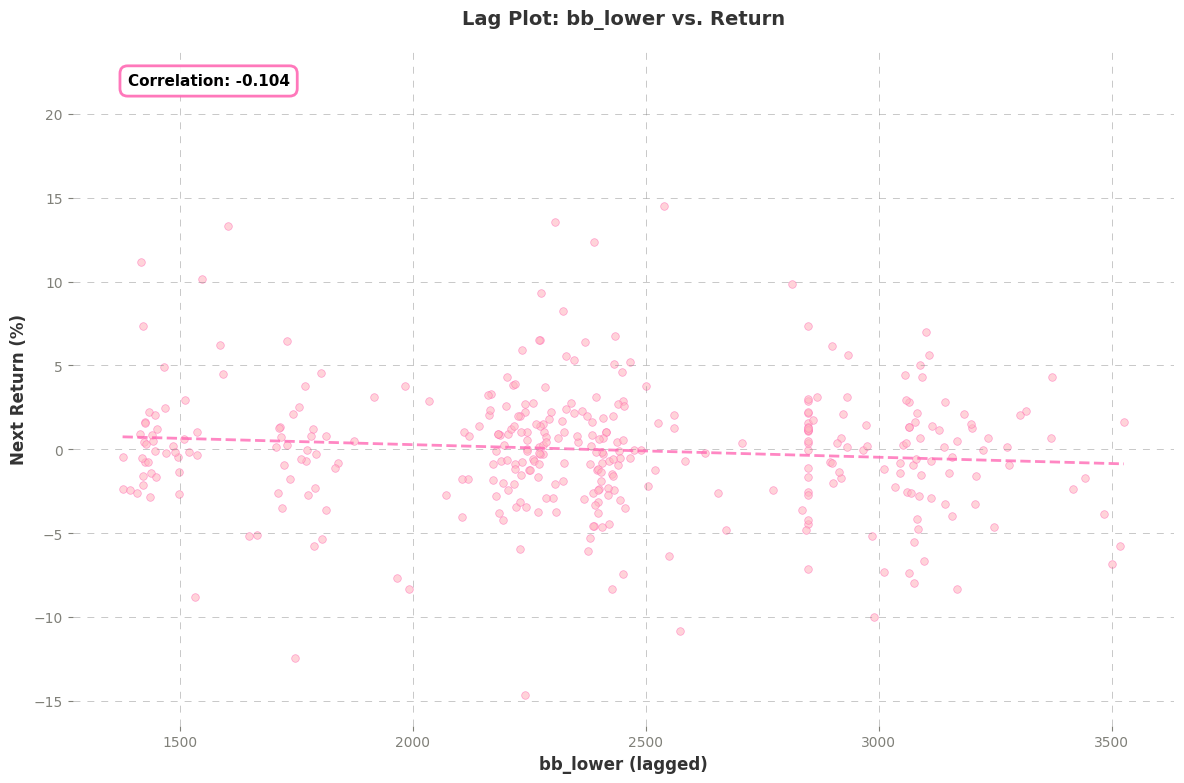

In [22]:
# plot for bb_lower vs return
fig, ax = plt.subplots(figsize=(12, 8))

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# color scheme
ax.scatter(df['bb_lower'].shift(1), df['return'], 
           alpha=0.6, 
           color='#FFB6C1', 
           s=30, 
           edgecolors='#FF69B4',
           linewidths=0.5)

# trend line
x = df['bb_lower'].shift(1).dropna()
y = df['return'][df['bb_lower'].shift(1).notna()]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x.sort_values(), p(x.sort_values()), 
        color='#FF69B4', linewidth=2, linestyle='--', alpha=0.8)

# calculate and display correlation
correlation = x.corr(y)
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', 
                 edgecolor='#FF69B4', linewidth=2, alpha=0.9))

# labels and title
ax.set_xlabel('bb_lower (lagged)', fontsize=12, color='#333333', fontweight='bold')
ax.set_ylabel('Next Return (%)', fontsize=12, color='#333333', fontweight='bold')
ax.set_title('Lag Plot: bb_lower vs. Return', fontsize=14, pad=20, 
             color='#333333', fontweight='bold')

# remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# tick labels
ax.tick_params(axis='x', colors='#808079')
ax.tick_params(axis='y', colors='#808079')
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]

plt.tight_layout()
plt.savefig("images/bb_lower_lag.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [ ]:
# FEAR AND GREED INDEX AND ETH RETURN GRANGER


df.index = pd.to_datetime(df.index)

# download fear and greed
def get_fear_greed(days=365):
    url = f"https://api.alternative.me/fng/?limit={days}&format=json"
    try:
        res = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=10)
        data = res.json().get('data', [])
        fg_df = pd.DataFrame(data)
        fg_df['date'] = pd.to_datetime(pd.to_numeric(fg_df['timestamp']), unit='s')
        fg_df['value'] = pd.to_numeric(fg_df['value'], errors='coerce')
        return fg_df.set_index('date')[['value']].sort_index()
    except Exception as e:
        print(f"Download failed: {e}")
        return None

fg = get_fear_greed()
fg = fg.rename(columns={"value": "fear_greed"})

# daily no double index
df_daily = df[~df.index.duplicated(keep='first')]

# merge
merged_df = df_daily[['return']].join(fg, how='inner')

# differences and standardization
merged_df['fg_diff'] = merged_df['fear_greed'].diff()
merged_df['fg_diff_std'] = (merged_df['fg_diff'] - merged_df['fg_diff'].mean()) / merged_df['fg_diff'].std()
merged_df['return_std'] = (merged_df['return'] - merged_df['return'].mean()) / merged_df['return'].std()
merged_df = merged_df.dropna()

print(f"\n=== Granger Causality Fear & Greed → ETH ===")
grangercausalitytests(merged_df[['return_std', 'fg_diff_std']], maxlag=5, verbose=True)



=== Granger Causality Fear & Greed → ETH ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0276  , p=0.3115  , df_denom=315, df_num=1
ssr based chi2 test:   chi2=1.0373  , p=0.3084  , df=1
likelihood ratio test: chi2=1.0357  , p=0.3088  , df=1
parameter F test:         F=1.0276  , p=0.3115  , df_denom=315, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0186  , p=0.3623  , df_denom=312, df_num=2
ssr based chi2 test:   chi2=2.0699  , p=0.3552  , df=2
likelihood ratio test: chi2=2.0632  , p=0.3564  , df=2
parameter F test:         F=1.0186  , p=0.3623  , df_denom=312, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3512  , p=0.2578  , df_denom=309, df_num=3
ssr based chi2 test:   chi2=4.1454  , p=0.2462  , df=3
likelihood ratio test: chi2=4.1185  , p=0.2490  , df=3
parameter F test:         F=1.3512  , p=0.2578  , df_denom=309, df_num=3

Granger Causality
number of lags (no zero) 4
ss

{1: ({'ssr_ftest': (1.0275570311205222, 0.3115111184415442, 315.0, 1),
   'ssr_chi2test': (1.0373432885597653, 0.3084401586577268, 1),
   'lrtest': (1.0356550076958229, 0.3088341597560899, 1),
   'params_ftest': (1.0275570311206177, 0.3115111184415199, 315.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.0186401380844827, 0.3622832860341614, 312.0, 2),
   'ssr_chi2test': (2.0699289985434683, 0.3552389919440225, 2),
   'lrtest': (2.0632002204069977, 0.3564361668770122, 2),
   'params_ftest': (1.018640138084495, 0.3622832860341614, 312.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3512043700857046, 0.2578421414307635, 309.0, 3),
   'ssr_chi2test': (4.145442533466822, 0.24618120141759348, 3),
   'lrtest': (4.1184870498160535, 0.24895064326198324, 3),
   'params_ftest': (1.3512043700856629, 0.2578421414307753, 309.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 

In [ ]:
# fear & greed index does not granger-cause ETH returns at any tested lag period (all p-values > 0.05)
# market sentiment, as measured by this index, does not provide predictive information for Ethereum price movements


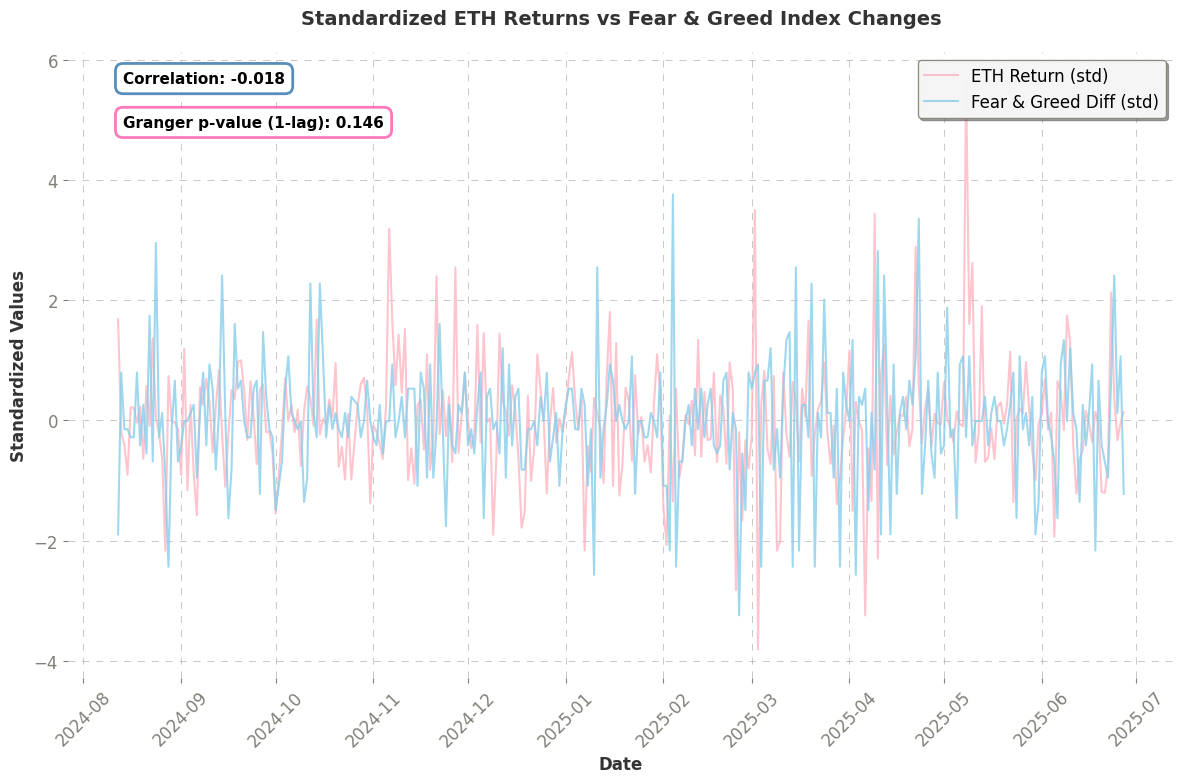

In [26]:
# visualizing relationship

# time series plot for fear and greed vs ETH returns
fig, ax = plt.subplots(figsize=(12, 8))
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# color scheme
eth_color = '#FFB6C1'
eth_edge = '#FF69B4'
fg_color = '#87CEEB'
fg_edge = '#4682B4'

# plot ETH returns
ax.plot(merged_df.index, merged_df['return_std'], 
        color=eth_color, linewidth=1.5, alpha=0.8, label='ETH Return (std)')

# plot fear and greed changes
ax.plot(merged_df.index, merged_df['fg_diff_std'], 
        color=fg_color, linewidth=1.5, alpha=0.8, label='Fear & Greed Diff (std)')

# calculate cross-correlation for display
correlation = merged_df['return_std'].corr(merged_df['fg_diff_std'])
ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
        transform=ax.transAxes, fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', 
                 edgecolor='#4682B4', linewidth=2, alpha=0.9))

# add granger test result
ax.text(0.05, 0.88, 'Granger p-value (1-lag): 0.146', 
        transform=ax.transAxes, fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', 
                 edgecolor='#FF69B4', linewidth=2, alpha=0.9))

# labels and title
ax.set_xlabel('Date', fontsize=12, color='#333333', fontweight='bold')
ax.set_ylabel('Standardized Values', fontsize=12, color='#333333', fontweight='bold')
ax.set_title('Standardized ETH Returns vs Fear & Greed Index Changes', 
             fontsize=14, pad=20, color='#333333', fontweight='bold')

# legend with custom styling
legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('#808079')
legend.get_frame().set_alpha(0.9)

# remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

# grid
ax.grid(True, color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)

# tick labels
ax.tick_params(axis='x', colors='#808079')
ax.tick_params(axis='y', colors='#808079')
[t.set_color('#808079') for t in ax.xaxis.get_ticklabels()]
[t.set_color('#808079') for t in ax.yaxis.get_ticklabels()]

# rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("images/fear_greed_eth_timeseries.png", dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [25]:
# GRANGER BTC ETH

# download BTC from binance
def download_btc():
    logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
    
    url = "https://api.binance.com/api/v1/klines"
    start_time = datetime.now() - timedelta(days=365)
    end_time = datetime.now()
    all_data = []

    while start_time < end_time:
        params = {
            "symbol": "BTCUSDT",
            "interval": "1d",
            "startTime": int(start_time.timestamp() * 1000),
            "endTime": int((start_time + timedelta(days=90)).timestamp() * 1000),
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            break
        
        data = response.json()
        if not data:
            break
            
        all_data.extend(data)
        start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(milliseconds=1)
        time.sleep(0.5)

    # Convert to df
    btc_df = pd.DataFrame(all_data, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ])
    
    btc_df["timestamp"] = pd.to_datetime(btc_df["timestamp"], unit="ms")
    btc_df.set_index("timestamp", inplace=True)
    btc_df["close"] = btc_df["close"].astype(float)
    
    return btc_df[["close"]]

# granger analysis
def comprehensive_granger_analysis(df, btc_df):
    
    # merge df on timestamp
    merged = pd.merge(
        df[['close']], 
        btc_df[['close']], 
        left_index=True, 
        right_index=True, 
        suffixes=('_eth', '_btc')
    ).dropna()
    
    print(f"Merged data shape: {merged.shape}")
    print(f"Date range: {merged.index.min()} to {merged.index.max()}")
    
    # calculate returns, log returns, and volatility
    merged['returns_eth'] = merged['close_eth'].pct_change()
    merged['returns_btc'] = merged['close_btc'].pct_change()
    merged['log_returns_eth'] = np.log(merged['close_eth']).diff()
    merged['log_returns_btc'] = np.log(merged['close_btc']).diff()
    merged['volatility_eth'] = merged['returns_eth'].rolling(7).std()
    merged['volatility_btc'] = merged['returns_btc'].rolling(7).std()
    
    # correlation analysis for comparison
    print("\n=== CORRELATION ANALYSIS ===")
    price_corr = merged['close_eth'].corr(merged['close_btc'])
    returns_corr = merged['returns_eth'].corr(merged['returns_btc'])
    log_returns_corr = merged['log_returns_eth'].corr(merged['log_returns_btc'])
    vol_corr = merged['volatility_eth'].corr(merged['volatility_btc'])
    
    print(f"Price correlation: {price_corr:.4f}")
    print(f"Returns correlation: {returns_corr:.4f}")  
    print(f"Log-returns correlation: {log_returns_corr:.4f}")
    print(f"Volatility correlation: {vol_corr:.4f}")
    
    # granger test on prices
    print("\n=== GRANGER TEST: PRICES ===")
    print("BTC → ETH:")
    granger_data_1 = merged[['close_eth', 'close_btc']].dropna()
    results_1 = grangercausalitytests(granger_data_1, maxlag=5, verbose=False)
    
    for lag in range(1, 6):
        if lag in results_1:
            p_value = results_1[lag][0]['ssr_ftest'][1]
            result = "YES" if p_value < 0.05 else "NO"
            print(f"  Lag {lag}: p={p_value:.4f}, Causality: {result}")
    
    print("ETH → BTC:")
    granger_data_2 = merged[['close_btc', 'close_eth']].dropna()
    results_2 = grangercausalitytests(granger_data_2, maxlag=5, verbose=False)
    
    for lag in range(1, 6):
        if lag in results_2:
            p_value = results_2[lag][0]['ssr_ftest'][1]
            result = "YES" if p_value < 0.05 else "NO"
            print(f"  Lag {lag}: p={p_value:.4f}, Causality: {result}")
    
    # granger test on returns
    print("\n=== GRANGER TEST: RETURNS ===")
    print("BTC Returns → ETH Returns:")
    granger_returns_1 = merged[['returns_eth', 'returns_btc']].dropna()
    if len(granger_returns_1) > 10:
        results_r1 = grangercausalitytests(granger_returns_1, maxlag=5, verbose=False)
        for lag in range(1, 6):
            if lag in results_r1:
                p_value = results_r1[lag][0]['ssr_ftest'][1]
                result = "YES" if p_value < 0.05 else "NO"
                print(f"  Lag {lag}: p={p_value:.4f}, Causality: {result}")
    
    print("ETH Returns → BTC Returns:")
    granger_returns_2 = merged[['returns_btc', 'returns_eth']].dropna()
    if len(granger_returns_2) > 10:
        results_r2 = grangercausalitytests(granger_returns_2, maxlag=5, verbose=False)
        for lag in range(1, 6):
            if lag in results_r2:
                p_value = results_r2[lag][0]['ssr_ftest'][1]
                result = "YES" if p_value < 0.05 else "NO"
                print(f"  Lag {lag}: p={p_value:.4f}, Causality: {result}")
    
    # granger test on volatility
    print("\n=== GRANGER TEST: VOLATILITY ===")
    print("BTC Volatility → ETH Volatility:")
    granger_vol_1 = merged[['volatility_eth', 'volatility_btc']].dropna()
    if len(granger_vol_1) > 10:
        results_v1 = grangercausalitytests(granger_vol_1, maxlag=3, verbose=False)
        for lag in range(1, 4):
            if lag in results_v1:
                p_value = results_v1[lag][0]['ssr_ftest'][1]
                result = "YES" if p_value < 0.05 else "NO"
                print(f"  Lag {lag}: p={p_value:.4f}, Causality: {result}")
    
    print("ETH Volatility → BTC Volatility:")
    granger_vol_2 = merged[['volatility_btc', 'volatility_eth']].dropna()
    if len(granger_vol_2) > 10:
        results_v2 = grangercausalitytests(granger_vol_2, maxlag=3, verbose=False)
        for lag in range(1, 4):
            if lag in results_v2:
                p_value = results_v2[lag][0]['ssr_ftest'][1]
                result = "YES" if p_value < 0.05 else "NO"
                print(f"  Lag {lag}: p={p_value:.4f}, Causality: {result}")
    
    # analysis of extreme movements
    print("\n=== EXTREME MOVEMENTS ===")
    eth_extreme = merged['returns_eth'].abs() > merged['returns_eth'].abs().quantile(0.9)
    btc_extreme = merged['returns_btc'].abs() > merged['returns_btc'].abs().quantile(0.9)
    
    extreme_together = (eth_extreme & btc_extreme).sum()
    total_eth_extreme = eth_extreme.sum()
    total_btc_extreme = btc_extreme.sum()
    
    print(f"ETH extreme days: {total_eth_extreme}")
    print(f"BTC extreme days: {total_btc_extreme}")
    print(f"Both extreme on same day: {extreme_together}")
    print(f"Percentage of synchronized extreme days: {extreme_together/max(total_eth_extreme, total_btc_extreme)*100:.1f}%")
    
    # summary interpretation
    print("\n=== INTERPRETATION SUMMARY ===")
    if returns_corr > 0.7:
        print("HIGH CORRELATION: BTC and ETH move together daily")
    elif returns_corr > 0.3:
        print("MODERATE CORRELATION: Some synchronized movement")
    else:
        print("LOW CORRELATION: Independent movements")

        
    sync_percentage = extreme_together/max(total_eth_extreme, total_btc_extreme)*100
    if sync_percentage > 60:
        print("HIGH SYNCHRONIZATION: Extreme movements often coincide")
    else:
        print("LOW SYNCHRONIZATION: Extreme movements are independent")

    
    return merged

# main execution
btc_df = download_btc()
merged_data = comprehensive_granger_analysis(df, btc_df)


Merged data shape: (320, 2)
Date range: 2024-08-12 00:00:00 to 2025-06-27 00:00:00

=== CORRELATION ANALYSIS ===
Price correlation: 0.3095
Returns correlation: 0.7910
Log-returns correlation: 0.7957
Volatility correlation: 0.7222

=== GRANGER TEST: PRICES ===
BTC → ETH:
  Lag 1: p=0.6992, Causality: NO
  Lag 2: p=0.8570, Causality: NO
  Lag 3: p=0.8969, Causality: NO
  Lag 4: p=0.7646, Causality: NO
  Lag 5: p=0.7219, Causality: NO
ETH → BTC:
  Lag 1: p=0.3444, Causality: NO
  Lag 2: p=0.4507, Causality: NO
  Lag 3: p=0.6587, Causality: NO
  Lag 4: p=0.8464, Causality: NO
  Lag 5: p=0.8563, Causality: NO

=== GRANGER TEST: RETURNS ===
BTC Returns → ETH Returns:
  Lag 1: p=0.4287, Causality: NO
  Lag 2: p=0.5090, Causality: NO
  Lag 3: p=0.5980, Causality: NO
  Lag 4: p=0.5649, Causality: NO
  Lag 5: p=0.6448, Causality: NO
ETH Returns → BTC Returns:
  Lag 1: p=0.0393, Causality: YES
  Lag 2: p=0.0941, Causality: NO
  Lag 3: p=0.2399, Causality: NO
  Lag 4: p=0.4004, Causality: NO
  Lag

In [ ]:
# key findings:
# strong daily correlation (0.791), BTC and ETH move together on same day
# moderate price correlation (0.310), different long-term trends but synchronized short-term movements
# high volatility correlation (0.722), risk regimes align between assets
# log-returns nearly identical (0.796), confirms robust relationship

#causal relationships:
# only 1 significant causal link found: ETH returns → BTC returns (1-day lag, p=0.0393)
# no BTC → ETH causality across any timeframe or metric
# no volatility causality in either direction
# no price level causality despite correlation

# extreme event analysis:
# 65.6% synchronization of extreme movements (21 out of 32 days)
# high crisis contagion -> when one asset crashes, the other often follows same day
# 32 extreme days each, identical extreme event frequency

# market structure insights:
# ETH leads BTC in return prediction (usually BTC leads altcoins)
# contemporaneous relationship dominant, movements happen together, not sequentially
# market efficiency confirmed for price levels (no predictive power)
# crisis correlation elevated but normal-time causality limited


# -> diversification limited during crises, 66% chance both assets move extremely together
# -> ETH volatility monitoring may provide 1-day BTC return signals
# ->same day risk management critical, predictive signals minimal
# ->despite 79% correlation, only one directional causal relationship exists
